<a id="top"></a>
# Parameter fit via Bayesian analysis

Use the parameter sample or sweep results conducted with MECSim to get the best fit parameters as well as statistically rigorous error bars for each parameter. 

Bayesian probability updater is used to convert the sum of squares values output from ``CompareSmoothed.py`` stored in the results file (``results.txt``) into the probability that a particular set of parameters is the correct model for matching the experimental data given that the correct set is within the investigated range.

This method will work for any number of parameters and can use prior probability data to improve the quality of the parameter fits.

This notebook can be run automatically as a python script (``BayesianAnalysis.py``) after running the parameter loop if setup in ``GenerateScript.ipynb`` or ``RandomlySampleRange.ipynb``. Doing so will use whatever general and plotting parameters set below and will not be interactive. Best proceedure is to edit and run this notebook using Jupyter to allow interactive analysis and error checking.

This notebook is structured with the input parameters at the start for ease of use. For interested users the methodology and theory are shown below.

The contents of this notebook are:
- <p><a href="#ref_paras">Parameters</a></p>
- <p><a href="#ref_plot_paras">Plotting parameters (optional)</a></p>
- <p><a href="#ref_readResults">Read sum of squares results </a></p>
- <p><a href="#ref_bayes_theory">Bayesian analysis theory</a></p>
- <p><a href="#ref_priors">Set priors</a></p>
- <p><a href="#ref_update">Bayesian update</a></p>
- <p><a href="#ref_posteriors">Output posterior probabilities</a></p>
- <p><a href="#ref_error_bars">Calculate error bars for all parameters</a></p>
- <p><a href="#ref_output_error_bars">Output error bars</a></p>
- <p><a href="#ref_plot_posteriors">Plot posterior probabilities and errors</a></p>


<a id="ref_paras"></a>
## Parameters

General parameters and file names which will be ignored depending on the specificed options.

In [54]:
# default name for results input file which constains som of squares comparison metric(s)
# this is output by script runs in the output directory
results_file_name_default = 'results.txt'

# set marker label in results header to mark when input variables are finished
header_marker = 'S'

# set how priors done (place in script directory)
iLoadPriors = False
priors_filename = "priors_sample.txt"

# output from this notebooks are sent to output directory by default
# save posterior file
iSavePosterior = True
posterior_filename = "posterior.txt"

# save parameter best fits
iSaveParameters = True
opt_para_filename = "opt_parameters.txt"

# flag to perform optimial parameters finding including error bars
#   (only useful for independent/simple runs at present)
iDoParameterOptimization = True

# Set an artifical minimum for the metric value(s) 
#   (to avoid Prob=1/0 if sum of squares = 0)
epsilon = 1.0e-6

<a id="ref_plot_paras"></a>
## Plotting parameters (optional)

Plot a contour plot for the final probabilities against two parameters selected by their column number in the results file.

In [55]:
# Plot output to png, pdf files)
iPlotOutput = True

# interactive mode for plotting to screen (turned off if in script mode)
iPlotInteractive = True

# select which columns to plot as parameters (x,y)
#   labels taken from column titles in results_file_name
ix = 0
iy = 1

# display optimal fit
iPlotFit = True

# display error bars
iPlotErrBars = False

# logscale for probabilities (coloured)
iPlotLogscale = False

# turn black outlined contours on/off
iUseContours = True

# label contours
iLabelContours = True

# plot colour mesh (at least this or contours should be true)
iPlotColourMesh = True

### Set default file locations

In [56]:
# output dir for results including the parent directory
output_dir = '../output/'
# script dir for results including the parent directory
script_dir = '../script/'

# default results file location
results_file_name = output_dir + results_file_name_default


## Load packages

In [57]:
# load system functions for inputting arguments at command line
import sys
import os
# load numpy
import numpy as np
# load interpolation function that supports irregular grids
from scipy.interpolate import NearestNDInterpolator
# load plotting functions if requested
if(iPlotOutput):
    from matplotlib import cm
    import matplotlib.pyplot as plt
    import matplotlib.mlab as ml

## Results file name

Determine the results file name to run the Bayesian analysis over. There are two options:

1. this file is run from the command line, so the first argument is the name of this python file (py rather than ipynb) and the second argument (if given) is the results file.
2. running in interactive mode e.g. via the jupyter notebook. In which case the default file name set above is used.

In [58]:
thisCodeName = 'BayesianAnalysis.py'
nLength = len(thisCodeName)
tailString = sys.argv[0]
tailString = tailString[-nLength:]
if(tailString==thisCodeName):
    if(len(sys.argv)>1):
        # next should be the file name
        results_file_name = sys.argv[1]
    # next should be the output directory name
    if(len(sys.argv)>2):
        output_dir = sys.argv[2]
    # next should be the script directory name
    if(len(sys.argv)>3):
        script_dir = sys.argv[3]
    iPlotInteractive = False
    results_file_name = output_dir + results_file_name

### Set filenames with correct directory structure

In [59]:
# posterior filename
posterior_filename = output_dir + posterior_filename
# optimial parameter output filename
opt_para_filename = output_dir + opt_para_filename
# prior filename from script directory
priors_filename = script_dir + priors_filename

<a id="ref_readResults"></a>
## Read results data

Use header line to determine the number of input parameters compared to the number of result values

In [60]:
lines = [line.rstrip('\n') for line in open(results_file_name)]

# first line is header line (remove $ from marker as well)
header_line = lines[0].replace('$', '')
header_line = header_line.split(',')

# find index for the results metric column header
output_first_index = header_line.index(header_marker)

# total length of data file (less header)
n_data = len(lines)-1

# loop read over data
input_data = []
for i in range(n_data):
    input_data.append(np.fromstring(lines[i+1].strip(), dtype=float, sep=','))
input_data = np.array(input_data)
n_cols = np.shape(input_data)[1]

Sort by parameters first - in case of an issue with loading priors later

In [61]:
input_data = input_data[input_data[:,(output_first_index-1)].argsort()]
for i in np.arange(output_first_index-2, -1, -1): # excludes stop so final is 0
    input_data = input_data[input_data[:,0].argsort(kind='mergesort')]

Collect input parameters and sum of squares metrics

In [62]:
input_parameters = input_data[0:n_data, 0:(output_first_index)]
input_metrics    = input_data[0:n_data, output_first_index:n_cols]

<a id="ref_bayes_theory"></a>
## Bayesian analysis theory

Conceptually each set of parameters $x_i$ is treated as a different model $M_i$ that can potentially fit the experimental data from a given experiment $D_k$. This experimental data can either be the sum of squares difference for a single harmonic (or dc) or the resulting metric when all harmonic fit data is combined via respective weights.

We seek to find the probability of each model ($M_i$) given the input of new experimental data ($D_k$), which we write as $P(M_i|D_k)$.

The probabilites for each model are updated via [Bayes theory](https://en.wikipedia.org/wiki/Bayes%27_theorem) which is written as:

$$
P(M_i|D_k) = \frac{ P(D_k | M_i) P(M_i) } { \sum_j P(D_k | M_j) P(M_j) }
$$

where $P(M_i)$ is the prior belief in model $M_i$ and the probability of the data given the model is related to the sum of squares metric comparing the experimental current response data ($D_k$) to the simulated current ($S_{ki}$) for the parameters ($x_i$) via

$$
P(D_k | M_i) \propto \frac{1}{S_{ki}}.
$$

Since the sum of squares metric can return zero for a perfect fit then we need to add a small term to ensure the probability does not go to infinity. Also we can remove the proportionality constant since any choice we make for it cancels out when we apply the form for Bayes theorem above. Thus
$$
P(D_k | M_i) = \frac{1}{S_{ki} + \epsilon}.
$$

where $\epsilon$ is much smaller than one, by default this is set as **epsilon** $10^{-6}$ above.

In applying this theorem the **prior** $P(M_i)$ is the pre-existing belief that a given model ($M_i$) is correct. Adding new comparison data will update our beliefs and output the **posterior** probabilities $P(M_i|D_k)$. If we have multiple data sets then the posterior values from our first set ($k=1$) can be used as the priors for the next set ($k=2$) and so on, further improving the accuracy of the posterior probabilities.

Note that these probabilities will always sum to one, i.e. $\sum_i P(M_i) = 1$, which implicitly assumes that the true model is somewhere within the parameter range input. This could result in misleading interpretations if, for example, the true model was for parameters well outside this range or a different electrochemical mechanism all together.

Back to <a href="#top">top</a>.

<a id="ref_priors"></a>
## Setting Priors

The priors are loaded in as a vector of probabilities with the same length as the number of parameter set combinations (**n_data**). Often their are no priors to be loaded, in which case they are assumed to be a uniform distribution.

**Caution** loading the priors can be tricky if you are using random sampling since the previously constructed sets of parameters will be different from the new parameter sets values. This is not a problem if the same grid with the same spacing is used such that all **input_parameters** are the same.

**Possible extention**: 
How do we update sets where we have no new data while correctly updating others?

**Current status**: For we assume the same grid is used for the priors as for the new data. This is ordered first as the new data can be unordered due to how it was generated (eg. parallel runs or multiple runs concatenated into a single file)

Back to <a href="#top">top</a>.

In [63]:
if(iLoadPriors):
    if(os.path.isfile(priors_filename)):
        print('Bayesian analysis: loading priors from ', priors_filename)
        # extract labels from header
        with open(priors_filename) as f:
            prior_header_line = f.readline()
        # read priors
        priors_full = np.loadtxt(priors_filename, delimiter=",", skiprows=1)
        priors_full = priors_full[priors_full[:,(output_first_index-1)].argsort()]
        for i in np.arange(output_first_index-2, -1, -1): # excludes stop so final is 0
            priors_full = priors_full[priors_full[:,0].argsort(kind='mergesort')]
            
        # ensure priors have the same structure as required (n_paras, values)
        if(np.shape(priors_full)[1] != output_first_index+1):
            iLoadPriors = False
        # sort into parameters and metrics
        priors_parameters = priors_full[:, 0:(output_first_index)]
        priors_metrics    = priors_full[:, output_first_index:(output_first_index+1)]

        n_p_data = np.shape(priors_full)[0]

        prior_parameters = priors_parameters.reshape(n_p_data, output_first_index)
        prior_values = priors_metrics.reshape((1, n_p_data)).T

        # build interpolator and estimate prior at new data points
        prior_interpolator = NearestNDInterpolator(x=prior_parameters, y=prior_values)
        priors = np.zeros(n_data)
        for i in range(n_data):
            priors[i] = prior_interpolator(input_parameters[i])
    
    else:
        # file doesnt exist
        iLoadPriors = False

('Bayesian analysis: loading priors from ', '../script/priors_sample.txt')


In [64]:
# no valid priors
if(not iLoadPriors):
    print('Bayesian analysis: using uniform priors')
    priors = np.full((n_data, 1), 1./n_data)

<a id="ref_update"></a>
## Uses Bayes theorm to update beliefs for each model

Loop over metrics and combine with Bayesian update.

Back to <a href="#top">top</a>.

In [65]:
n_metrics = np.shape(input_metrics)[1]
P_Mi = priors
posteriors_store = []
# get P(D_k | M_i)
for k in range(n_metrics):
    sos_ki = input_metrics[0:n_data, k]
    P_Dk_Mi = np.divide(1.0, sos_ki + epsilon)
    P_Dk_Mi_P_Mi = np.array([P_Dk_Mi[i]*P_Mi[i] for i in range(n_data)])
    P_sum = np.array(P_Dk_Mi_P_Mi).sum()
    if(P_sum > 0.0):
        P_Mi_Dk = np.array([P_Dk_Mi_P_Mi[i] / P_sum for i in range(n_data)]).reshape(n_data)
    else: # no new data - posterior = prior
        P_Mi_Dk = P_Mi
    # store posterior for this harmonic/metric
    posteriors_store.append(P_Mi_Dk)
    # set prior for next round to current posterior
    P_Mi = P_Mi_Dk
# transform output into a array of correct length
posteriors_store = np.array(posteriors_store)

<a id="ref_posteriors"></a>
## Save posteriors

Save csv text file with the input metrics as well as the posterior values for each harmonic.

Back to <a href="#top">top</a>.

In [66]:
parameters = input_parameters.reshape(n_data, output_first_index)
values     = posteriors_store.reshape((n_metrics, n_data)).T
posterior  = np.concatenate((parameters, values), axis=1)

Output to csv file

In [67]:
if(iSavePosterior):
    header_text = ','.join(header_line)
    np.savetxt(posterior_filename, posterior, fmt='%.8e', delimiter=",", 
               header=header_text, comments='')

<a id="ref_error_bars"></a>
## Calculate error bars

For each parameter calculate the standard deviation (in each direction) based on the probabilities given all other parameters are fixed at their optimal values.

### Build interpolator function

Interpolate to get the $x_{\pm \sigma}$ for each direction - cut at $x_{min/max}$ to avoid extrapolation to unrealistic values. So if $0 < x < 1$ then $x_{+\sigma}$ and $x_{-\sigma}$ must also be in this range

To determine the probabilities probabilities along each line we use a simple nearest neighbour interpolator in N dimensions. Note that if resolution is poor then the resulting interpolations along each line will be a series of discrete steps. Even in this low resolution extreme we still get quite good values for the error bars.

Back to <a href="#top">top</a>.

In [68]:
interpolator = NearestNDInterpolator(x=parameters, y=values)

### Loop over each parameter

Loop over each parameter along the range of possible values while fixing all other parameters to their optimal values.

**In development** - need to extend this to non-grid runs

In [69]:
# Optimal parameters (default is they exist)
iHaveOpt = True
# find optimal parameters
if(iDoParameterOptimization):
    n_res = 100
    opt_index = np.argmax(P_Mi_Dk)
    opt_paras = input_parameters[opt_index,:]
    opt_min = np.min(parameters, axis=0)
    opt_max = np.max(parameters, axis=0)
    opt_para_p = opt_paras.copy()
    opt_para_m = opt_paras.copy()
    for i in range(len(opt_paras)):
        # create x_i line
        opt_xi = np.linspace(opt_min[i], opt_max[i], num=n_res, endpoint=True)
        val_xi = opt_xi.copy()
        opt_test = opt_paras.copy()
        for j in range(len(opt_xi)):
            opt_test[i] = opt_xi[j]
            val_xi[j] = interpolator(opt_test)
        # scale in xi direction by sum_xi
        sum_xi = np.sum(val_xi)
        val_xi = val_xi/sum_xi
        cum_xi = np.cumsum(val_xi)
        # interpolate for med - 1 st.dev = 0.159
        opt_para_m[i] = np.interp(0.159, cum_xi, opt_xi)
        # interpolate for med + 1 st.dev = 0.841
        opt_para_p[i] = np.interp(0.841, cum_xi, opt_xi)
    print("Bayesian analysis optimization results:")
    print("  opt-1sd = ", opt_para_m)
    print("  opt     = ", opt_paras)
    print("  opt+1sd = ", opt_para_p)
else:
    # nothing to output so nothing to save
    iSaveParameters = False
    # Optimal parameters
    iHaveOpt = False

Bayesian analysis optimization results:
('  opt-1sd = ', array([ 0.0082282 , -0.01756245]))
('  opt     = ', array([0.01, 0.  ]))
('  opt+1sd = ', array([0.01169255, 0.01551991]))


<a id="ref_output_error_bars"></a>
### Output optimal and errors


Output the optimal value and error bars for parameter $x_i$ for each row in the output file with a format of:

    parameter label (e.g. 'Ezero'), x_opt, x_opt - 1 standard deviation, x_opt + 1 standard deviation

Back to <a href="#top">top</a>.

In [70]:
if(iSaveParameters):
    # round values
    opt_para_m_out = np.reshape(np.round(opt_para_m, 8), (len(opt_paras), 1))
    opt_paras_out  = np.reshape(np.round(opt_paras,  8), (len(opt_paras), 1))
    opt_para_p_out = np.reshape(np.round(opt_para_p, 8), (len(opt_paras), 1))
    # reshape parameter headers
    para_label = np.reshape(np.array(header_line[0:len(opt_paras_out)]), (len(opt_paras_out), 1))
    # join to single np.array for output
    opt_para_array_out = np.concatenate((para_label, opt_paras_out, opt_para_m_out, opt_para_p_out), axis=1)
    # output to text file (since some text then set format to string for all - numbers come out as %f without problem)
    np.savetxt(opt_para_filename, opt_para_array_out, fmt='%s', delimiter=",")

<a id="ref_plot_posteriors"></a>
## Plot posteriors

Plot the posterior probabilities for two selected parameters to ``bayesian_plot.pdf`` and ``bayesian_plot.png``. Settings such as contours or colour mesh plot as well as aesthetics are specified at the top of this notebook.


Back to <a href="#top">top</a>.

('Bayesian posterior probabilities for:', 'kzero', 'Ezero')


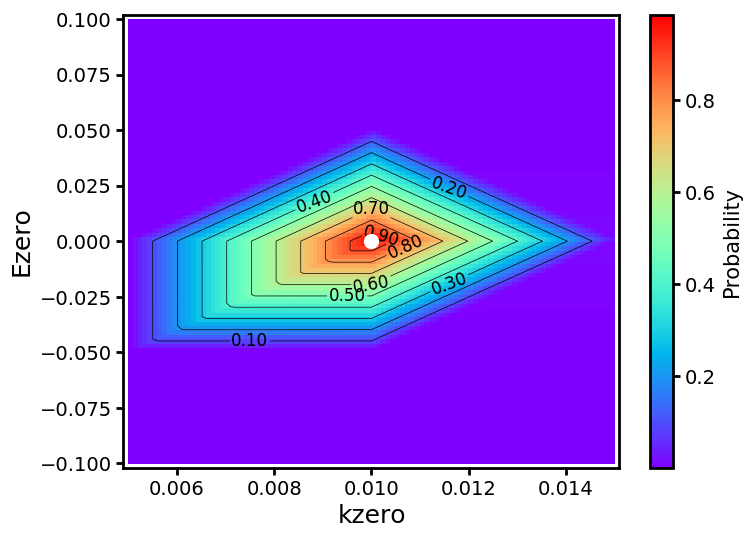

In [71]:
if(iPlotOutput):
    # set names
    x_name = header_line[ix]
    y_name = header_line[iy]
    
    print("Bayesian posterior probabilities for:", x_name, y_name)
    
    # set to interactive mode if requested
    if(iPlotInteractive):
        %matplotlib inline

    # select data for plot with Bayesian probability
    x = input_parameters[0:n_data, ix]
    y = input_parameters[0:n_data, iy]
    z = P_Mi_Dk

    # find min/max for plotting variables
    xplotmin = np.min(x)
    xplotmax = np.max(x)
    yplotmin = np.min(y)
    yplotmax = np.max(y)

    # optimal value and error bars
    if(iHaveOpt):
        x_opt = opt_paras[ix]
        y_opt = opt_paras[iy]
        x_err_m = x_opt - opt_para_m[ix]
        y_err_m = y_opt - opt_para_m[iy]
        x_err_p = opt_para_p[ix] - x_opt
        y_err_p = opt_para_p[iy] - y_opt
    
    # set overall data resolution
    ny, nx = 100, 100

    # buffer settings
    bufFactor = 100.
    bufX = (xplotmax - xplotmin)/bufFactor
    bufY = (yplotmax - yplotmin)/bufFactor
    
    # calculate x, y axes grids
    deltax = (xplotmax - xplotmin)/float(nx)
    deltay = (yplotmax - yplotmin)/float(ny)
    xmin = xplotmin-bufX
    xmax = xplotmax+bufX
    ymin = yplotmin-bufY
    ymax = yplotmax+bufY
    xi = np.arange(xmin-bufX, xmax+bufX, deltax)
    yi = np.arange(ymin-bufY, ymax+bufY, deltay)
    # convert to log(z) if requested
    if(iPlotLogscale):
        z = np.log10(z)
    zi = ml.griddata(x, y, z, xi, yi, interp='linear') # 'nn' for incomplete data; 'linear' if complete

    # setup aesthetics for figure
    plt.figure(figsize=(8,6),dpi=100)
    plt.rcParams['xtick.major.size'] = 5
    plt.rcParams['xtick.major.width'] = 2
    plt.rcParams['xtick.minor.size'] = 3
    plt.rcParams['xtick.minor.width'] = 2
    plt.rcParams['ytick.major.size'] = 5
    plt.rcParams['ytick.major.width'] = 2
    plt.rcParams['ytick.minor.size'] = 3
    plt.rcParams['ytick.minor.width'] = 2
    plt.rcParams['axes.linewidth'] = 2
    plt.rcParams['lines.linewidth'] = 2
    plt.rcParams['xtick.labelsize'] = 14
    plt.rcParams['ytick.labelsize'] = 14
    plt.rcParams['contour.negative_linestyle'] = 'solid'
    plt.rcParams['xtick.direction'] = 'out'
    plt.rcParams['ytick.direction'] = 'out'
    plt.ticklabel_format(axis='y', style='sci', scilimits=(-2,2))
    # setup the contours (black outlines)
    if(iUseContours):
        CS = plt.contour(xi, yi, zi, 10, linewidths = 0.5, colors = 'k')
        # Define a class that forces representation of float to look a certain way
        # This remove trailing zero so '1.0' becomes '1'
        class nf(float):
            def __repr__(self):
                str = '%.2f' % (self.__float__(),)
                if str[-1] == '0':
                    return '%.2f' % self.__float__()
                else:
                    return '%.2f' % self.__float__()
        # Recast levels to new class
        CS.levels = [nf(val) for val in CS.levels]
        # label the contours
        if(iLabelContours):
            # Label levels with specially formatted floats
            if plt.rcParams["text.usetex"]:
                fmt = r'%r'
            else:
                fmt = '%r'
            plt.clabel(CS, CS.levels, inline=True, fmt=fmt, fontsize=12)

        
    if(iPlotColourMesh):
        plt.pcolormesh(xi, yi, zi, cmap = plt.get_cmap('rainbow'))
    if(iPlotLogscale):
        plt.colorbar().set_label(label='log$_{10}$P',size=15)
    else:
        plt.colorbar().set_label(label='Probability',size=15)
    # plot error bars
    if(iPlotErrBars):
        plt.errorbar(x=x_opt, y=y_opt, xerr=[[x_err_m], [x_err_p]], yerr=[[y_err_m], [y_err_p]], 
                     fmt='--o', ecolor='k', elinewidth=4, capsize=10, capthick=4)
        plt.errorbar(x=x_opt, y=y_opt, xerr=[[x_err_m], [x_err_p]], yerr=[[y_err_m], [y_err_p]], 
                     fmt='--o', ecolor='w', elinewidth=2, capsize=8, capthick=2)
    # plot optimal values
    if(iPlotFit and iHaveOpt):
        plt.scatter(x_opt, y_opt, marker = 'o', c = 'white', s = 100, zorder = 10)

    # set x/y limits
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
    # change x/y labels
    plt.xlabel(x_name, fontsize=18)
    plt.ylabel(y_name, fontsize=18)
    # save figures to PDF and png
    plt.savefig(output_dir + "bayesian_plot.pdf", dpi=400)
    plt.savefig(output_dir + "bayesian_plot.png", dpi=400)
    if(iPlotInteractive):
        plt.show()